In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import os

os.chdir('../../../data/')
pd.options.display.float_format = '{:.5f}'.format

## Load data

In [2]:
transactions_df = pd.read_csv('transactions_train.csv')
customers_df = pd.read_csv('customers.csv')
articles_df = pd.read_csv('articles.csv')

## Analysis of customers.csv file

In [3]:
customers_df.head(10)

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,NaN,NaN,ACTIVE,NONE,49.00000,52043ee2162cf5aa7ee79974281641c6f11a68d276429a...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,NaN,NaN,ACTIVE,NONE,25.00000,2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,NaN,NaN,ACTIVE,NONE,24.00000,64f17e6a330a85798e4998f62d0930d14db8db1c054af6...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,NaN,ACTIVE,NONE,54.00000,5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,1.00000,1.00000,ACTIVE,Regularly,52.00000,25fa5ddee9aac01b35208d01736e57942317d756b32ddd...
5,000064249685c11552da43ef22a5030f35a147f723d5b0...,NaN,NaN,NaN,NaN,NaN,2c29ae653a9282cce4151bd87643c907644e09541abc28...
6,0000757967448a6cb83efb3ea7a3fb9d418ac7adf2379d...,NaN,NaN,ACTIVE,NONE,20.00000,fe7b8e2b3fafb89ca90db17ffeeae0fd29b795d803f749...
7,00007d2de826758b65a93dd24ce629ed66842531df6699...,1.00000,1.00000,ACTIVE,Regularly,32.00000,8d6f45050876d059c830a0fe63f1a4c022de279bb68ce3...
8,00007e8d4e54114b5b2a9b51586325a8d0fa74ea23ef77...,NaN,NaN,ACTIVE,NONE,20.00000,2c29ae653a9282cce4151bd87643c907644e09541abc28...
9,00008469a21b50b3d147c97135e25b4201a8c58997f787...,NaN,NaN,ACTIVE,NONE,20.00000,2c29ae653a9282cce4151bd87643c907644e09541abc28...


In [4]:
customers_df.info()  # basic info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355969 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


In [5]:
customers_df.isna().sum() / len(customers_df)  # missing values percentage

customer_id              0.00000
FN                       0.65238
Active                   0.66151
club_member_status       0.00442
fashion_news_frequency   0.01167
age                      0.01156
postal_code              0.00000
dtype: float64

In [6]:
customers_df.isna().sum()

customer_id                    0
FN                        895050
Active                    907576
club_member_status          6062
fashion_news_frequency     16011
age                        15861
postal_code                    0
dtype: int64

### Customer_id

In [7]:
assert len(customers_df) == len(customers_df['customer_id'].unique())  # check for duplicates
assert customers_df.customer_id.isna().sum() == 0  # check for missing values

### FN

In [8]:
display(customers_df.FN.value_counts(dropna=False)/ len(customers_df))

FN
NaN       0.65238
1.00000   0.34762
Name: count, dtype: float64

### Active

In [9]:
display(customers_df.Active.value_counts(dropna=False) / len(customers_df))

Active
NaN       0.66151
1.00000   0.33849
Name: count, dtype: float64

#### overlap with FN

In [10]:
customers_df[['FN', 'Active']].fillna(0).corr()  # correlation between FN and Active

,FN,Active
FN,1.00000,0.97995
Active,0.97995,1.00000


### club_member_status

In [11]:
display(customers_df.club_member_status.value_counts(dropna=False)/ len(customers_df)) 

club_member_status
ACTIVE       0.92749
PRE-CREATE   0.06776
NaN          0.00442
LEFT CLUB    0.00034
Name: count, dtype: float64

### fashion_news_frequency

In [12]:
display(customers_df.fashion_news_frequency.value_counts(dropna=False)/ len(customers_df)) 

fashion_news_frequency
NONE        0.63974
Regularly   0.34798
NaN         0.01167
Monthly     0.00061
Name: count, dtype: float64

#### overlap with FN and Active

Here I check to see the overlap between FN, Active and fashion_news_frequency columns. The overlap is very high, for the columns, so we the assumption that missing values in FN and Active corresponds to people that are not signed up for communication is likely true. Also because there is such a high corellation, it should be safe to use only fashion_news_frequency column later, as it was the one with least missing values.

<Axes: >

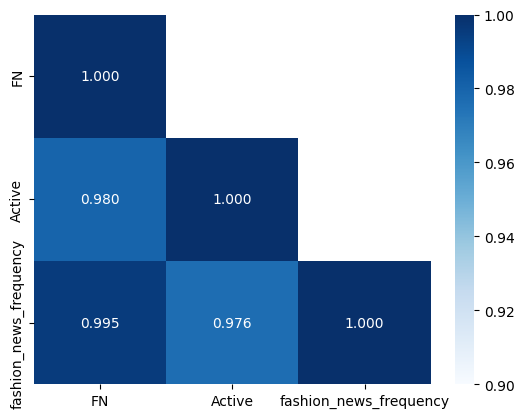

In [13]:
active_map = {'NONE':0, 'Regularly':1, 'Monthly':1}

corr = customers_df[['FN', 'Active', 'fashion_news_frequency']].fillna(0).replace(active_map).corr() 
sns.heatmap(corr, annot=True, fmt=".3f", cmap='Blues', vmin=0.9, mask=np.triu(corr, k=1))

### age

In [14]:
display(customers_df.age.describe())

count   1356119.00000
mean         36.38696
std          14.31363
min          16.00000
25%          24.00000
50%          32.00000
75%          49.00000
max          99.00000
Name: age, dtype: float64

<Axes: >

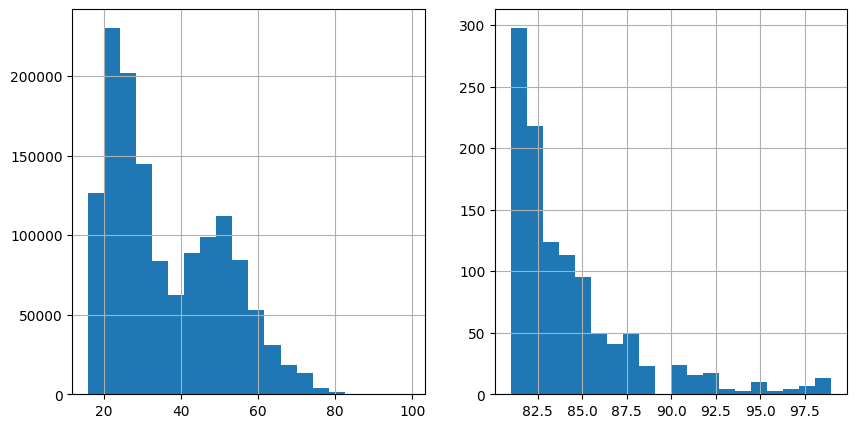

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

customers_df.age.hist(bins=20, ax=ax[0])
customers_df[customers_df.age > 80].age.hist(bins=20, ax=ax[1])


### postal_code

In [16]:
display(len(customers_df.postal_code.unique()))

352899

In [17]:
display(customers_df.postal_code.value_counts(dropna=False).head(10))

postal_code
2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c    120303
cc4ed85e30f4977dae47662ddc468cd2eec11472de6fac5ec985080fd92243c8       261
714976379549eb90aae4a71bca6c7402cc646ae7c40f6c1cb91d4b5a18623fc1       159
7c1fa3b0ec1d37ce2c3f34f63bd792f3b4494f324b6be5d1e4ba6a75456b96a7       157
5b7eb31eabebd3277de632b82267286d847fd5d44287ee150bb4206b48439145       156
1f5bd429acc88fbbf24de844a59e438704aa8761bc7b99fd977cad297c50b74c       154
9d5787501bf1c77592156ba51eab13f4a2670c807686431a9e22a69090b02358       141
a1959a16bf167858c93a66ec2a330644512b25fb10f97eee2058549885af4dbd       138
087a46b65170845b4a55226ff1eb748ce7843d4b637cbe17f6bfbd1e645d2ffb       134
4d22901a97bd952bb92cdd31b38c39b41dd3250a735cabdfac1503eb405b807d       132
Name: count, dtype: int64

### missing values in all columns

Investigate whether customers that have missing values in all columns except customer_id and postal_code made only offline purchases -- YES.

In [18]:
# customers_df.iloc[256186]
na_cust = customers_df[customers_df[['FN', 'Active', 'club_member_status', 'fashion_news_frequency', 'age']].isna().all(axis=1)]

display(na_cust.postal_code.value_counts())

# Only offline sales channel
display(transactions_df[transactions_df.customer_id.isin(na_cust.customer_id)].sales_channel_id.value_counts())

display(transactions_df[transactions_df.customer_id.isin(na_cust.customer_id)].groupby(['customer_id']).nunique())


postal_code
2c29ae653a9282cce4151bd87643c907644e09541abc28ae87dea0d1f6603b1c    2012
a745f02e151bf7a4197428bed7638532ca1d7a324824c889583c3074bcadafe0       1
Name: count, dtype: int64

sales_channel_id
2    12525
Name: count, dtype: int64

,t_dat,article_id,price,sales_channel_id
customer_id,,,,
000064249685c11552da43ef22a5030f35a147f723d5b02ddd9fd22452b1f5a6,1,3,2,1
004d89470677ce579a313b2259e93b07ea6f944686f9c34368d742ee0dc8cfa9,1,2,1,1
008681443e68c3e60a686217a704187dd38abffd2c09622a0a23214383b1357d,4,15,6,1
009551a25130f6746582fa98f30a599cc0ecd907a4abe7077451e99986d12234,1,2,2,1
00bf3e96c1fae4377e7c88652fde0aad44404336dc8141289c83c615dd7d4c0a,1,1,1,1
...,...,...,...,...
ff1b22d4bb208109861e34f27762cb7f71ad7b71965f7ba3684bd7493eb82ef3,1,1,1,1
ff46140c7166175ee98dc6f54048986c3883ec382d87a85be771a68ff7d06575,3,6,4,1
ff6bcfbd940ff03ebe31c0a1e94ee87125d101038ca60075fa849f44f95710ac,3,7,5,1


## Analysis of articles.csv file

### Generate profiling report

In [19]:
# !ydata_profiling --title 'Articles Report' ../../data/articles.csv articles_report.html

In [20]:
articles_df.head()

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
0,108775015,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,9,Black,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
1,108775044,108775,Strap top,253,Vest top,Garment Upper body,1010016,Solid,10,White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
2,108775051,108775,Strap top (1),253,Vest top,Garment Upper body,1010017,Stripe,11,Off White,...,Jersey Basic,A,Ladieswear,1,Ladieswear,16,Womens Everyday Basics,1002,Jersey Basic,Jersey top with narrow shoulder straps.
3,110065001,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,9,Black,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."
4,110065002,110065,OP T-shirt (Idro),306,Bra,Underwear,1010016,Solid,10,White,...,Clean Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Microfibre T-shirt bra with underwired, moulde..."


In [21]:
articles_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

### Unique values

In [22]:
articles_df.nunique()

article_id                      105542
product_code                     47224
prod_name                        45875
product_type_no                    132
product_type_name                  131
product_group_name                  19
graphical_appearance_no             30
graphical_appearance_name           30
colour_group_code                   50
colour_group_name                   50
perceived_colour_value_id            8
perceived_colour_value_name          8
perceived_colour_master_id          20
perceived_colour_master_name        20
department_no                      299
department_name                    250
index_code                          10
index_name                          10
index_group_no                       5
index_group_name                     5
section_no                          57
section_name                        56
garment_group_no                    21
garment_group_name                  21
detail_desc                      43404
dtype: int64

In [25]:
len(articles_df.drop_duplicates()) == len(articles_df)  # including article_id gives no duplicates

True

In [26]:
len(articles_df.drop_duplicates(subset=articles_df.columns[1:])) == len(articles_df)  # excluding article_id gives duplicates

False

In [88]:
len(articles_df[articles_df.duplicated(subset=articles_df.columns[1:], keep=False)])  # number of duplicates

9369

### Article ID

In [27]:
art_art_id = set(articles_df.article_id)

# Check if all article ids in transactions are in articles metadata
for val in tqdm.tqdm(transactions_df.article_id):
    assert val in art_art_id

# Check if all article ids in article metadata were bought at least once -- if not we can actually drop them
trans_art_id = set(transactions_df.article_id)
count = 0
for val in tqdm.tqdm(art_art_id):
    if val not in trans_art_id:
        count += 1

print('Articles that were never bought: ', f'{count / len(art_art_id) * 100:.2f}', '%.')

100%|██████████| 105542/105542 [00:00<00:00, 4279163.96it/s]

Articles that were never bought:  0.94 %.


### Corresponding int vs str columns

Check if columns with corresponding names have all values with 1 to 1 mapping. If yes - we can drop one of these columns without any info loss.

#### product_type_name vs product_type_no


In [28]:
def check_correspondence(df, col1, col2):
    grouped_1 = df.groupby(col1)[col2].nunique()
    grouped_2 = df.groupby(col2)[col1].nunique()  # check both ways
    mismatched_col1 = df[df[col2].isin(grouped_2[grouped_2 != 1].index.tolist())][[col1, col2]].drop_duplicates().values.tolist()
    mismatched_col2 = df[df[col1].isin(grouped_1[grouped_1 != 1].index.tolist())][[col2, col1]].drop_duplicates().values.tolist()
    return mismatched_col1 + mismatched_col2

In [29]:
print('Unique values in product_type_no columns: ', len(articles_df.product_type_no.unique()))
print('Unique values in product_type_name columns: ', len(articles_df.product_type_name.unique()))

print(check_correspondence(articles_df, 'product_type_no', 'product_type_name'))

Unique values in product_type_no columns:  132
Unique values in product_type_name columns:  131
[[532, 'Umbrella'], [83, 'Umbrella']]


We could drop `product_type_name` column, as `product_type_no` contains more values (and we know which values we can group if we want). Or we can keep both for now as it might be useful to decode features while explaining predictions.

#### graphical_appearance_no vs graphical_appearance_name

In [30]:
print('Unique values in graphical_appearance_no columns: ', len(articles_df.graphical_appearance_no.unique()))
print('Unique values in graphical_appearance_name columns: ', len(articles_df.graphical_appearance_name.unique()))

print(check_correspondence(articles_df, 'graphical_appearance_no', 'graphical_appearance_name'))

Unique values in graphical_appearance_no columns:  30
Unique values in graphical_appearance_name columns:  30
[]


We could drop `graphical_appearance_name` column, as `graphical_appearance_no` contains same values, only mapped to numbers (or we can do the opposite, so that later we may decode group codes).

#### colour_group_code vs colour_group_name

In [259]:
print('Unique values in colour_group_code columns: ', len(articles_df.colour_group_code.unique()))
print('Unique values in colour_group_name columns: ', len(articles_df.colour_group_name.unique()))

print(check_correspondence(articles_df, 'colour_group_code', 'colour_group_name'))

Unique values in colour_group_code columns:  50
Unique values in colour_group_name columns:  50
[]


We could drop `colour_group_name` column, as `colour_group_code` contains same values, only mapped to numbers (or we can do the opposite, so that later we may decode group codes).

#### perceived_colour_value_id vs perceived_colour_value_name

In [260]:
print('Unique values in perceived_colour_value_id columns: ', len(articles_df.perceived_colour_value_id.unique()))
print('Unique values in perceived_colour_value_name columns: ', len(articles_df.perceived_colour_value_name.unique()))

print(check_correspondence(articles_df, 'perceived_colour_value_id', 'perceived_colour_value_name'))

Unique values in perceived_colour_value_id columns:  8
Unique values in perceived_colour_value_name columns:  8
[]


We could drop `perceived_colour_value_name` column, as `perceived_colour_value_id` contains same values, only mapped to numbers (or we can do the opposite, so that later we may decode group codes).

#### perceived_colour_master_id vs perceived_colour_master_name

In [261]:
print('Unique values in perceived_colour_master_id columns: ', len(articles_df.perceived_colour_master_id.unique()))
print('Unique values in perceived_colour_master_name columns: ', len(articles_df.perceived_colour_master_name.unique()))

print(check_correspondence(articles_df, 'perceived_colour_master_id', 'perceived_colour_master_name'))

Unique values in perceived_colour_master_id columns:  20
Unique values in perceived_colour_master_name columns:  20
[]


We could drop `perceived_colour_master_name` column, as `perceived_colour_master_id` contains same values, only mapped to numbers (or we can do the opposite, so that later we may decode group codes).

#### department_no vs department_name

In [262]:
print('Unique values in department_no columns: ', len(articles_df.department_no.unique()))
print('Unique values in department_name columns: ', len(articles_df.department_name.unique()))

print(check_correspondence(articles_df, 'department_no', 'department_name'))

Unique values in department_no columns:  299
Unique values in department_name columns:  250
[[1676, 'Jersey Basic'], [5883, 'Jersey Basic'], [2032, 'Jersey'], [4342, 'EQ & Special Collections'], [3509, 'Belts'], [4242, 'Swimwear'], [5783, 'Shirt'], [5683, 'Trouser'], [3946, 'Small Accessories'], [5656, 'Trouser'], [9985, 'Accessories'], [3209, 'Bags'], [1626, 'Knitwear'], [2031, 'Woven bottoms'], [5658, 'Shorts'], [1722, 'Trouser'], [5882, 'Jersey Fancy'], [3944, 'Bags'], [1919, 'Jersey'], [1939, 'Woven bottoms'], [1745, 'Shorts'], [5878, 'Knitwear'], [7389, 'Belts'], [5828, 'Jersey Fancy'], [3439, 'EQ & Special Collections'], [9986, 'Small Accessories'], [1717, 'Trouser'], [5687, 'Shorts'], [5831, 'Knitwear'], [1666, 'Jersey'], [5631, 'Trouser'], [5731, 'Shirt'], [1949, 'Knitwear'], [1201, 'Outwear'], [5884, 'Knitwear'], [5686, 'Trouser'], [1422, 'Skirt'], [1670, 'Jersey License'], [1641, 'Jersey'], [9984, 'Swimwear'], [5777, 'Shirt'], [5555, 'Blazer'], [2034, 'Knitwear'], [1414, 'Ski

We could drop `department_name` column, as it contains less values, however we need to remember that maybe it's better to group them later in feature engineering phase, so for now its better to keep both.

#### index_code vs index_name

In [263]:
print('Unique values in index_code columns: ', len(articles_df.index_code.unique()))
print('Unique values in index_name columns: ', len(articles_df.index_name.unique()))

print(check_correspondence(articles_df, 'index_code', 'index_name'))

Unique values in index_code columns:  10
Unique values in index_name columns:  10
[]


We could drop `index_name` column, as `index_code` contains same values, only mapped to numbers (or we can do the opposite, so that later we may decode group codes).

#### index_group_no vs index_group_name

In [264]:
print('Unique values in index_group_no columns: ', len(articles_df.index_group_no.unique()))
print('Unique values in index_group_name columns: ', len(articles_df.index_group_name.unique()))

print(check_correspondence(articles_df, 'index_group_no', 'index_group_name'))

Unique values in index_group_no columns:  5
Unique values in index_group_name columns:  5
[]


We could drop `index_group_name` column, as `index_group_no` contains same values, only mapped to numbers (or we can do the opposite, so that later we may decode group codes).

#### section_no vs section_name

In [265]:
print('Unique values in section_no columns: ', len(articles_df.section_no.unique()))
print('Unique values in section_name columns: ', len(articles_df.section_name.unique()))

print(check_correspondence(articles_df, 'section_no', 'section_name'))

Unique values in section_no columns:  57
Unique values in section_name columns:  56
[[4, 'Ladies Other'], [17, 'Ladies Other']]


We could drop `section_name` column, as `section_no` contains more values (and we know which values we can group if we want). Or we can keep both for now as it might be useful to decode features while explaining predictions.

#### garment_group_no vs garment_group_name

In [244]:
print('Unique values in garment_group_no columns: ', len(articles_df.garment_group_no.unique()))
print('Unique values in garment_group_name columns: ', len(articles_df.garment_group_name.unique()))

print(check_correspondence(articles_df, 'garment_group_no', 'garment_group_name'))

Unique values in garment_group_no columns:  21
Unique values in garment_group_name columns:  21
[]


We could drop `garment_group_name` column, as `garment_group_no` contains same values, only mapped to numbers (or we can do the opposite, so that later we may decode group codes).

To sum up this part, most integer columns are the same as string columns, which means there is possiblity for high reduction of dataset memory, while preserving all information (int types use less memory than string, and in all pairs int columns are same or more specific to string). However before doing that we need to ensure that there will be no need to explain the model or look deeper at features, and then working with only numbers might be hard. Because of that for now it is safer to keep both columns, but also remember which ones may be safely removed and which ones will need a bit more work to be done (`section_no`, `department_no`, `product_type_no`).

### Check -1 values in columns

All -1 values stand for Unknown categories. Even though these might be missing values in this column, we cannot drop them as this is our metadata, so if there is other useful info we may use it.

In [237]:
articles_df.min(numeric_only=True)

article_id                    108775015
product_code                     108775
product_type_no                      -1
graphical_appearance_no              -1
colour_group_code                    -1
perceived_colour_value_id            -1
perceived_colour_master_id           -1
department_no                      1201
index_group_no                        1
section_no                            2
garment_group_no                   1001
dtype: int64

In [325]:
for pair in [
    ('product_type_no', 'product_type_name'), 
    ('graphical_appearance_no', 'graphical_appearance_name'), 
    ('colour_group_code', 'colour_group_name'), 
    ('perceived_colour_value_id', 'perceived_colour_value_name'), 
    ('perceived_colour_master_id', 'perceived_colour_master_name')
    ]:

    print(pair[0], articles_df[articles_df[pair[0]]==-1][pair[1]].unique()) 

product_type_no ['Unknown']
graphical_appearance_no ['Unknown']
colour_group_code ['Unknown']
perceived_colour_value_id ['Unknown']
perceived_colour_master_id ['Unknown']


##### All -1 values correspond to `Unknown` value in descriptive column - it can be either replacement of missing values or we can treat it as a separate category.

### Index group name and product group name

Two columns with least unique values - possible to see something about data.

- Index group name - children / women / men / sport / ???universal???
- Product group name -- broad description of product group

<Axes: xlabel='Count', ylabel='index_group_name'>

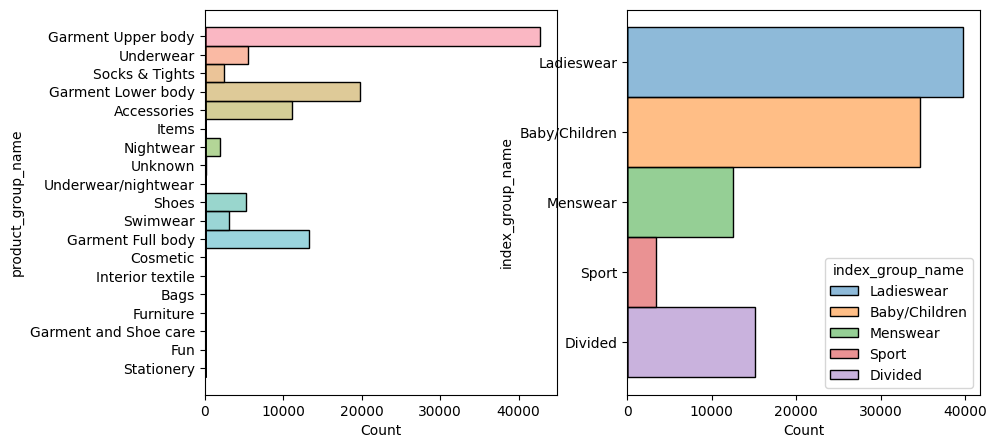

In [67]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.histplot(data=articles_df, y='product_group_name', hue='product_group_name', ax=ax[0], legend= False)
sns.histplot(data=articles_df, y='index_group_name', hue='index_group_name', ax=ax[1])

<Axes: xlabel='Count', ylabel='product_group_name'>

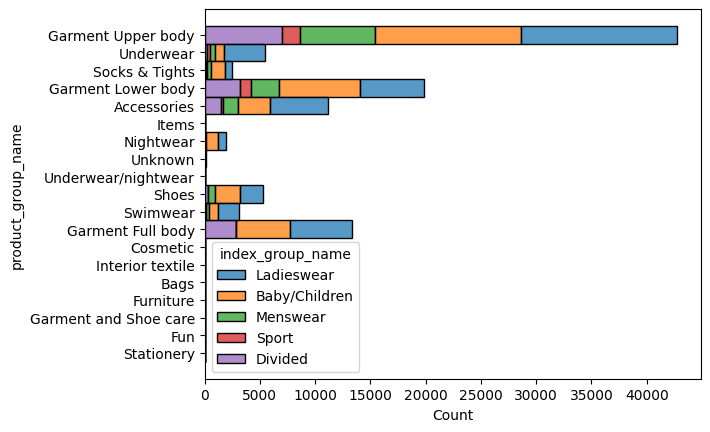

In [60]:
sns.histplot(data=articles_df, y='product_group_name', hue='index_group_name', multiple='stack')

<Axes: xlabel='Count', ylabel='index_name'>

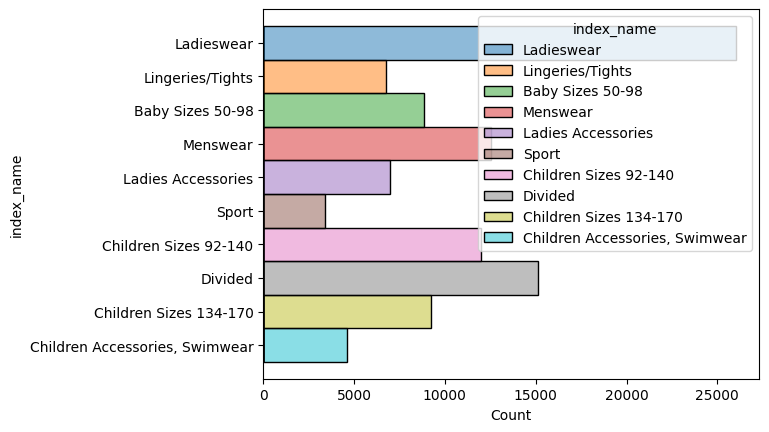

In [71]:
sns.histplot(data=articles_df, y='index_name', hue='index_name')

<Axes: xlabel='Count', ylabel='perceived_colour_value_name'>

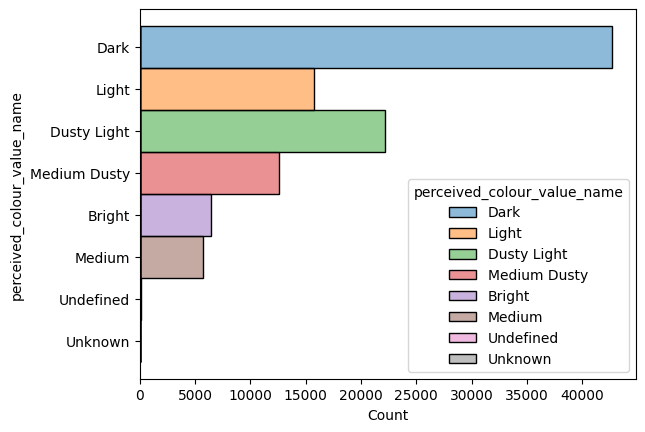

In [70]:
sns.histplot(data=articles_df, y='perceived_colour_value_name', hue='perceived_colour_value_name')

<Axes: xlabel='Count', ylabel='graphical_appearance_name'>

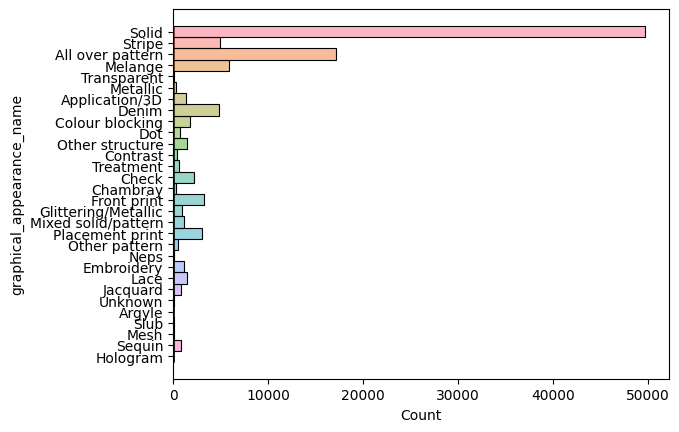

In [73]:
sns.histplot(data=articles_df, y='graphical_appearance_name', hue='graphical_appearance_name', legend=False)

We can see that most purchased items are by far upper body ones, where the second place goes to lower body items. Half of the groups has really low purchase rate, it might be good to remember about that and possibly refrain from recommending them as their sales are very low.

Furthermore most items purchased are from category `Ladiesware`, closely followed by `Baby/Children` category. Least amount of purchases contains `Sport` items.

## Analysis of transactions_train.csv

In [31]:
transactions_df.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,663713001,0.05083,2
1,2018-09-20,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,541518023,0.03049,2
2,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,505221004,0.01524,2
3,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687003,0.01693,2
4,2018-09-20,00007d2de826758b65a93dd24ce629ed66842531df6699...,685687004,0.01693,2


In [32]:
transactions_df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 6.3 GB


### No Missing values - no NA's

In [33]:
transactions_df.isna().sum()

t_dat               0
customer_id         0
article_id          0
price               0
sales_channel_id    0
dtype: int64

### Total transactions

Assume one transactions per customer per day.

In [34]:
grouped_transactions = transactions_df.\
    groupby(['t_dat', 'customer_id', 'sales_channel_id']).\
        agg({'article_id':'count', 'price':'sum'}).\
            reset_index().sort_values(['customer_id', 't_dat'])

grouped_transactions[['article_id', 'price']].describe()

,article_id,price
count,9174457.00000,9174457.00000
mean,3.46487,0.09642
std,3.58980,0.11198
min,1.00000,0.00002
25%,1.00000,0.03388
50%,2.00000,0.06097
75%,4.00000,0.11520
max,570.00000,22.47976


In [35]:
# Most transactions are small (few items)
grouped_transactions.article_id.value_counts()

article_id
1      2752079
2      2154149
3      1319088
4       886285
5       551549
        ...   
176          1
180          1
99           1
153          1
148          1
Name: count, Length: 151, dtype: int64

In [36]:
# Total transactions assuming 1 transaction per day per customer
len(grouped_transactions)

9174457

### Plot of sales in time

Check amount of sales per day per channel (offline vs online) on the entire training period. We can see that there are some spikes (probably promotions, holidays etc.) which are not really of interest. But there is also an interesting period - namely COVID period where stores were closed and no offline transactions were recorded. It is important to remember about that so that this artifact will not affect the models or feature engineering in project's later phase.

In [37]:
transactions_df['t_dat'] = pd.to_datetime(transactions_df.t_dat)
data_by_day_channel = transactions_df.groupby(['t_dat', 'sales_channel_id']).agg({'price': 'sum'}).reset_index()

In [38]:
data_by_day_channel.head()

,t_dat,sales_channel_id,price
0,2018-09-20,1,342.49325
1,2018-09-20,2,1072.85259
2,2018-09-21,1,382.66915
3,2018-09-21,2,1036.59315
4,2018-09-22,1,223.81308


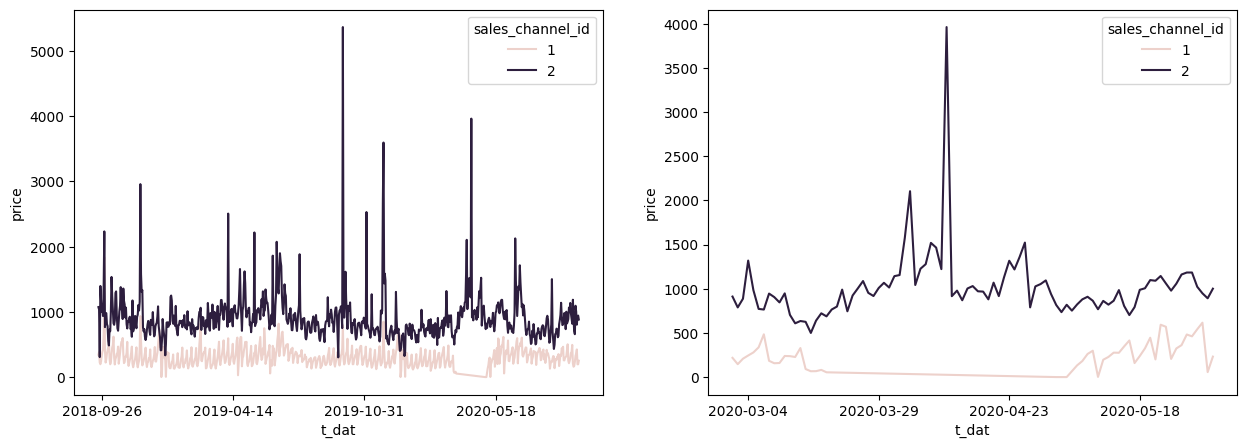

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.lineplot(data=data_by_day_channel, x='t_dat', y='price', hue='sales_channel_id', ax=ax[0])
sns.lineplot(data=data_by_day_channel[(data_by_day_channel.t_dat >= '2020-03-01') & (data_by_day_channel.t_dat <= '2020-06-01')], x='t_dat', y='price', hue='sales_channel_id', ax=ax[1])

ax[0].xaxis.set_major_locator(plt.MaxNLocator(5))
ax[1].xaxis.set_major_locator(plt.MaxNLocator(5))

plt.show()

#### Check dates without offline sales - Covid period

In [40]:
counts = data_by_day_channel.t_dat.value_counts()
min(counts[counts ==1].index), max(counts[counts ==1].index), len(counts[counts ==1].index)

(Timestamp('2020-03-20 00:00:00'), Timestamp('2020-05-05 00:00:00'), 45)

### Customer_id feature

Check that all customers in transactions are present in customers metadata. 

In [41]:
cust_cust_id = set(customers_df.customer_id)

# Check if all customer ids in transactions are in customers metadata
for val in tqdm.tqdm(transactions_df.customer_id):
    assert val in cust_cust_id

# Check if all customer ids in customers metadata made a transaction
trans_cust_id = set(transactions_df.customer_id)
count = 0
for val in tqdm.tqdm(cust_cust_id):
    if val not in trans_cust_id:
        count += 1

print('Customers that never made a transaction: ', f'{count / len(cust_cust_id) * 100:.2f}', '%.')

100%|██████████| 1371980/1371980 [00:00<00:00, 2489498.73it/s]

Customers that never made a transaction:  0.71 %.


### T_dat feature 

All dates, first and last date.

In [42]:
transactions_df.t_dat.min(), transactions_df.t_dat.max(), len(transactions_df.t_dat.unique())

(Timestamp('2018-09-20 00:00:00'), Timestamp('2020-09-22 00:00:00'), 734)

### Price feature

Price variable cannot be analysed conventionally as it has been scaled. We can see however that while looking for most expensive and cheapest items, they seem to reflect the true order (premiums, collaborations expensive vs accessories, underwear as cheapest). However they distribution seems to be highly skewed possibly due to outliers.

In [43]:
transactions_df.price.describe()

count   31788324.00000
mean           0.02783
std            0.01918
min            0.00002
25%            0.01581
50%            0.02541
75%            0.03388
max            0.59153
Name: price, dtype: float64

In [44]:
expensive = transactions_df.sort_values(by='price', ascending=False).head(100).article_id.unique()[:5]

In [45]:
display(articles_df[articles_df.article_id.isin(expensive)])

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
37399,653551001,653551,Benji leather jacket,262,Jacket,Garment Upper body,1010016,Solid,12,Light Beige,...,Outwear & Blazers,A,Ladieswear,1,Ladieswear,18,Womens Trend,1008,Dressed,Leather jacket in a longer style with a collar...
41862,670485001,670485,PE ELLA COAT,262,Jacket,Garment Upper body,1010016,Solid,73,Dark Blue,...,Take Care External,A,Ladieswear,1,Ladieswear,97,Collaborations,1001,Unknown,"Straight-cut coat in a soft, felted wool and c..."
50826,697511001,697511,PE LINDA LEATHER COAT,263,Coat,Garment Upper body,1010016,Solid,93,Dark Green,...,Take Care External,A,Ladieswear,1,Ladieswear,97,Collaborations,1001,Unknown,"Coat in soft, supple leather with wide notch l..."
103842,916300001,916300,PQ OLGA LEATHER DRESS,265,Dress,Garment Full body,1010016,Solid,43,Dark Red,...,Woven Premium,A,Ladieswear,1,Ladieswear,14,Womens Premium,1001,Unknown,Knee-length shirt dress in soft leather with a...
103843,916300002,916300,PQ OLGA LEATHER DRESS,265,Dress,Garment Full body,1010016,Solid,9,Black,...,Woven Premium,A,Ladieswear,1,Ladieswear,14,Womens Premium,1001,Unknown,Knee-length shirt dress in soft leather with a...


In [46]:
cheapest = transactions_df.sort_values(by='price', ascending=False).tail(100).article_id.unique()[-5:]

In [47]:
display(articles_df[articles_df.article_id.isin(cheapest)])

,article_id,product_code,prod_name,product_type_no,product_type_name,product_group_name,graphical_appearance_no,graphical_appearance_name,colour_group_code,colour_group_name,...,department_name,index_code,index_name,index_group_no,index_group_name,section_no,section_name,garment_group_no,garment_group_name,detail_desc
143,186264016,186264,10p Terry w.o. Clip,73,Hair string,Accessories,1010016,Solid,13,Beige,...,Hair Accessories,C,Ladies Accessories,1,Ladieswear,66,Womens Small accessories,1019,Accessories,Hair elastics without metal clips.
8484,523490001,523490,5p Plastic Terry,512,Hair ties,Accessories,1010016,Solid,9,Black,...,Hair Accessories,C,Ladies Accessories,1,Ladieswear,66,Womens Small accessories,1019,Accessories,Coiled plastic hair elastics.
10560,541758001,541758,5p tie terry,73,Hair string,Accessories,1010016,Solid,9,Black,...,Hair Accessories,C,Ladies Accessories,1,Ladieswear,66,Womens Small accessories,1019,Accessories,Hair elastics with a knot. Width 1.5 cm.
48716,692979004,692979,Oprah Bikini Lotus Low,286,Underwear bottom,Underwear,1010016,Solid,42,Red,...,Expressive Lingerie,B,Lingeries/Tights,1,Ladieswear,61,Womens Lingerie,1017,"Under-, Nightwear","Lace bikini briefs with a low waist, lined gus..."
56806,715052001,715052,Connor blouse,258,Blouse,Garment Upper body,1010001,All over pattern,43,Dark Red,...,Projects Woven Tops,D,Divided,2,Divided,50,Divided Projects,1010,Blouses,Long-sleeved blouse in a viscose weave with a ...


<Axes: xlabel='price', ylabel='Density'>

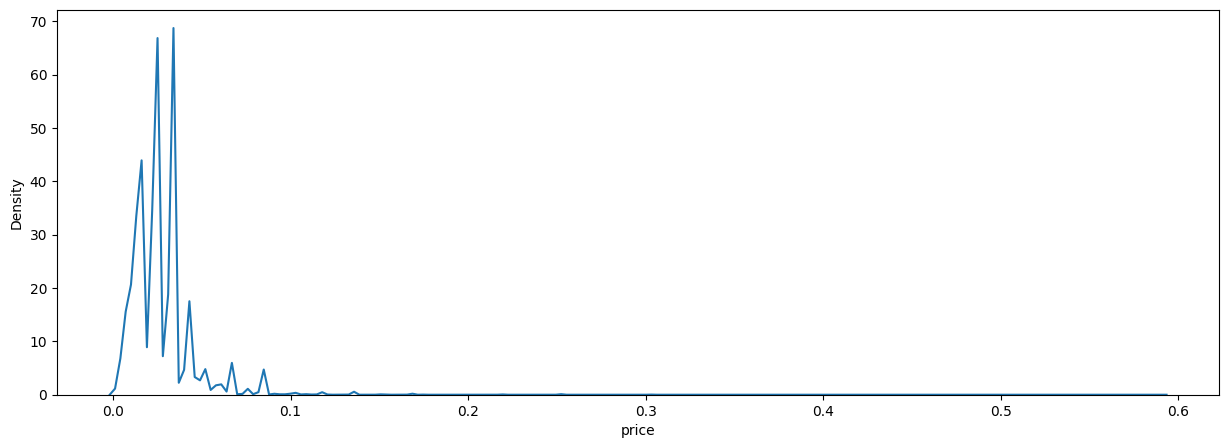

In [48]:
fig, ax = plt.subplots(figsize=(15, 5))
# plt.figure(figsize=(15, 5))

sns.kdeplot(transactions_df.price, ax=ax)

<Axes: xlabel='price'>

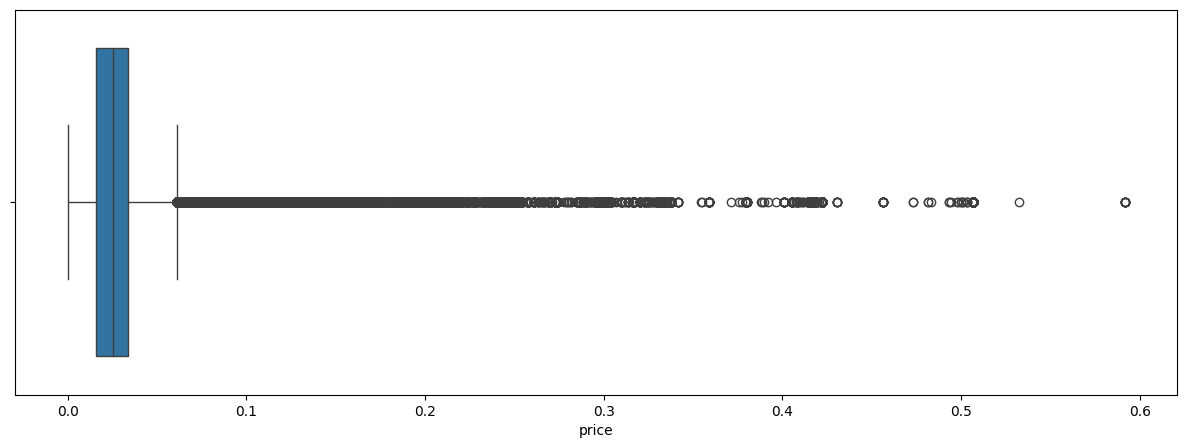

In [49]:
fig, ax = plt.subplots(figsize=(15, 5))

sns.boxplot(transactions_df.price, orient='h', ax=ax)

Many outliers in price variable are present.

### Sales channel feature

- 1 for offline
- 2 for online

In [50]:
transactions_df.sales_channel_id.value_counts() / len(transactions_df)

sales_channel_id
2   0.70403
1   0.29597
Name: count, dtype: float64

In [51]:
grouped_transactions.sales_channel_id.value_counts() / len(grouped_transactions)

sales_channel_id
2   0.59859
1   0.40141
Name: count, dtype: float64